<a href="https://www.kaggle.com/code/iqmansingh/machine-failures-xgb-lgbm?scriptVersionId=134407032" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark")
print("Setup Complete")

/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv
/kaggle/input/machine-failure-predictions/machine failure.csv
Setup Complete


# Importing Datasets

In [2]:
train_path = "../input/playground-series-s3e17/train.csv"
orig_path = "../input/machine-failure-predictions/machine failure.csv"
test_path = "../input/playground-series-s3e17/test.csv"

train_data = pd.read_csv(train_path,index_col="id")
orig_data = pd.read_csv(orig_path,index_col="UDI")
test_data = pd.read_csv(test_path,index_col="id")

train_data = train_data.append(orig_data)
train_data.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [3]:
print(train_data.info(),test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146429 entries, 0 to 10000
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               146429 non-null  object 
 1   Type                     146429 non-null  object 
 2   Air temperature [K]      146429 non-null  float64
 3   Process temperature [K]  146429 non-null  float64
 4   Rotational speed [rpm]   146429 non-null  int64  
 5   Torque [Nm]              146429 non-null  float64
 6   Tool wear [min]          146429 non-null  int64  
 7   Machine failure          146429 non-null  int64  
 8   TWF                      146429 non-null  int64  
 9   HDF                      146429 non-null  int64  
 10  PWF                      146429 non-null  int64  
 11  OSF                      146429 non-null  int64  
 12  RNF                      146429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 15.6+ MB
<c

In [4]:
train_data.drop(["Product ID"],inplace=True,axis=1)
test_data.drop(["Product ID"],inplace=True,axis=1)

In [5]:
test_data.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF',
       'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

# Data Cleaning

In [6]:
train_data.columns = ['Type', 'Air_Temp_K', 'Process_Temp_K', 'Rot_Speed', 'Torque',
       'Tool_Wear', 'Machine_Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
test_data.columns = ['Type', 'Air_Temp_K', 'Process_Temp_K', 'Rot_Speed', 'Torque',
       'Tool_Wear', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

catDTypeCols = ['Type']

In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

train_data["Type"] = encoder.fit_transform(train_data["Type"])
test_data["Type"] = encoder.transform(test_data["Type"])
train_data.head()

,Type,Air_Temp_K,Process_Temp_K,Rot_Speed,Torque,Tool_Wear,Machine_Failure,TWF,HDF,PWF,OSF,RNF
0,1,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,2,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,1,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,1,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,2,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [8]:
train_data["Temp_Diff"] = train_data["Process_Temp_K"]-train_data["Air_Temp_K"]
test_data["Temp_Diff"] = test_data["Process_Temp_K"]-test_data["Air_Temp_K"]

train_data["Air_Temp_C"] = train_data["Air_Temp_K"]-273
test_data["Air_Temp_C"] = test_data["Air_Temp_K"]-273

train_data["Process_Temp_C"] = train_data["Process_Temp_K"]-273
test_data["Process_Temp_C"] = test_data["Process_Temp_K"]-273

train_data["Power"] = train_data["Torque"]*train_data["Rot_Speed"]
test_data["Power"] = test_data["Torque"]-test_data["Rot_Speed"]

# Normalizing Data

In [9]:
train_data.columns

Index(['Type', 'Air_Temp_K', 'Process_Temp_K', 'Rot_Speed', 'Torque',
       'Tool_Wear', 'Machine_Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF',
       'Temp_Diff', 'Air_Temp_C', 'Process_Temp_C', 'Power'],
      dtype='object')

In [10]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler

numericalCols = ['Air_Temp_K','Air_Temp_C','Process_Temp_C','Process_Temp_K','Rot_Speed','Torque','Tool_Wear','Temp_Diff',"Power"]

train_nor = train_data.copy()
test_nor = test_data.copy()

for i in numericalCols:
    x = np.array(train_data[i]).reshape(-1,1)
    scaler = MaxAbsScaler()
    scaler.fit(x)
    train_nor[i] = scaler.fit_transform(x).reshape(1,-1)[0]
    
for i in numericalCols:
    x = np.array(test_data[i]).reshape(-1,1)
    scaler = MaxAbsScaler()
    scaler.fit(x)
    test_nor[i] = scaler.fit_transform(x).reshape(1,-1)[0]

# Exploratory Data Analysis

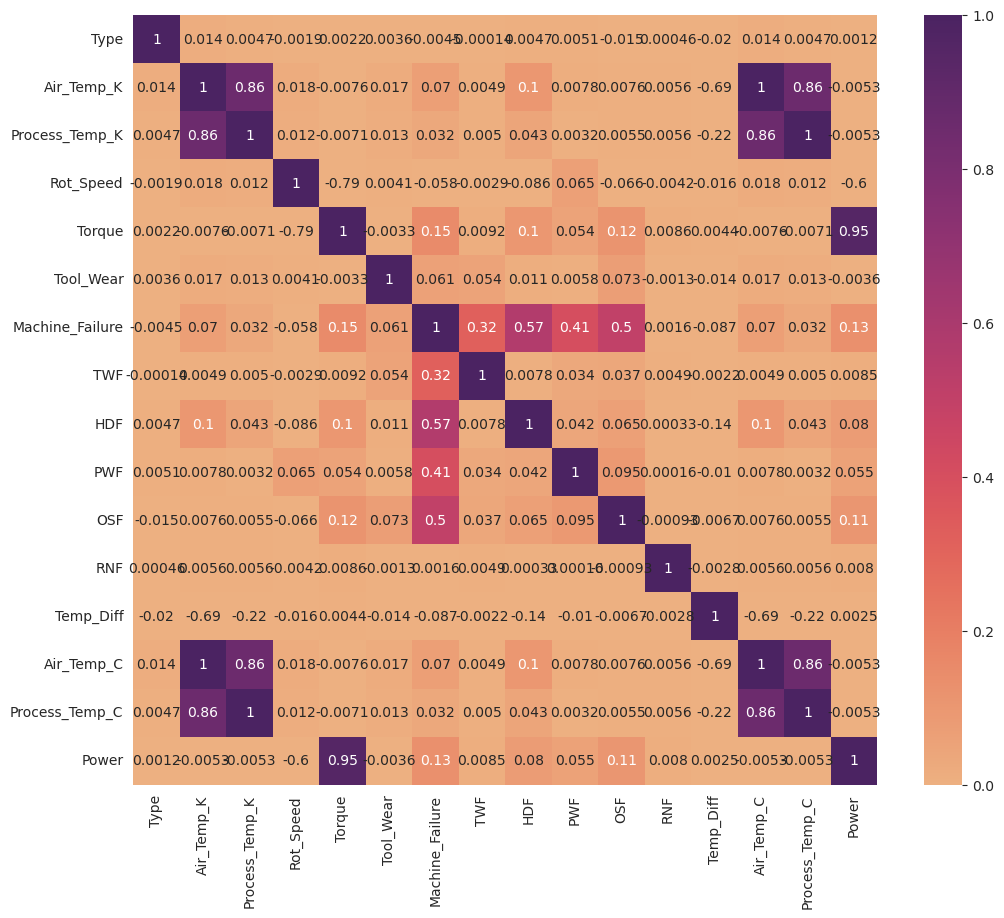

In [11]:
features = [i for i in train_data.columns]
corr = train_nor[features].corr(numeric_only=False)
plt.figure(figsize = (12,10))
sns.heatmap(corr, cmap = 'flare', annot = True,vmin=0);
plt.show()

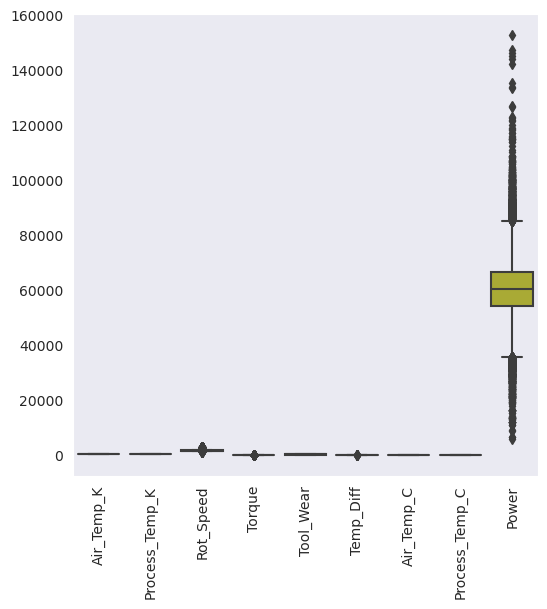

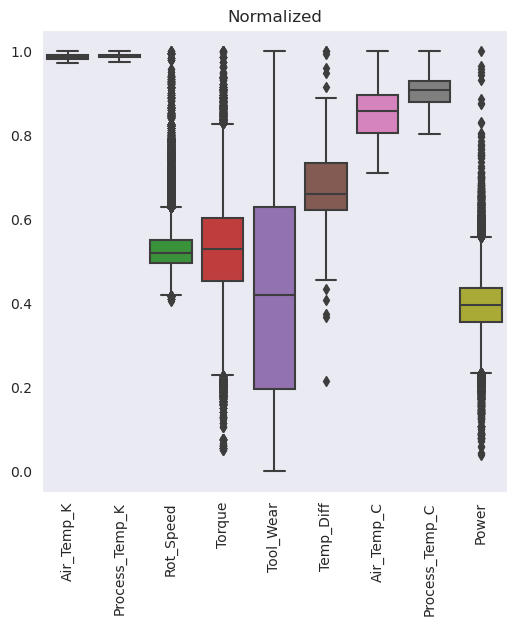

In [12]:
plotCols = [i for i in train_data.columns if len(train_nor[i].unique())>3]

plt.figure(figsize=(6,6))
sns.boxplot(train_data[plotCols]);
plt.xticks(rotation=90)
plt.show();

plt.figure(figsize=(6,6))
plt.title("Normalized")
sns.boxplot(train_nor[plotCols])
plt.xticks(rotation=90);

In [13]:
for i in plotCols:
    plt.figure(figsize=(6,4))
    sns.histplot(train_nor,x =i,hue="Machine_Failure",bins=40,kde=True);
    plt.show()

# Training Model 

In [22]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [23]:
cols = [i for i in train_nor.columns if i!="Machine_Failure"]
seed = np.random.seed(0)

X = train_nor[cols]
y = train_nor["Machine_Failure"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,random_state=seed)

## XGB

In [24]:
params_xgb  = {
    'n_estimators':[1500, 2000],
    'learning_rate': [0.02, 0.01],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

best_params_xgb = {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 2000}

xgbmodel = XGBClassifier(**best_params_xgb,random_state=seed,eval_metric= "auc",tree_method='gpu_hist', predictor='gpu_predictor')
xgbmodel.fit(X,y)
# grid_search_xgb = GridSearchCV(xgbmodel, params_xgb, cv=5, verbose=3, scoring="roc_auc")
# grid_search_xgb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=2000, n_jobs=None, num_parallel_tree=None,
              predictor='gpu_predictor', random_state=None, ...)

In [26]:
# df = pd.DataFrame()
# df["imp"] = grid_search_xgb.best_estimator_.feature_importance_

In [27]:
print("-"*50,"\n")
print("ROC Area Under Curve of XGB:",roc_auc_score(y_test, xgbmodel.predict_proba(X_test)[:,1]))

-------------------------------------------------- 

ROC Area Under Curve of XGB: 0.9796061495986913


## LGBMClassifier

In [32]:
lgbmmodel = LGBMClassifier(random_state=seed,device='gpu')

params_lbgm  = {
    'n_estimators':[1500, 2000],
    'learning_rate': [0.02, 0.01],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
            }

grid_search_lgbm = GridSearchCV(lgbmmodel, params_lbgm, cv=5, verbose=3, scoring="roc_auc")
grid_search_lgbm.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1500;, score=0.969 total time=  13.0s
[CV 2/5] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1500;, score=0.961 total time=   8.5s
[CV 3/5] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1500;, score=0.963 total time=   7.6s
[CV 4/5] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1500;, score=0.969 total time=   7.7s
[CV 5/5] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1500;, score=0.984 total time=   7.6s
[CV 1/5] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=2000;, score=0.969 total time=  11.0s
[CV 2/5] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=2000;, score=0.959 total time=  10.1s
[CV 3/5] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=2000;, score=0.962 total time=  10.1s
[C

GridSearchCV(cv=5, estimator=LGBMClassifier(device='gpu'),
             param_grid={'learning_rate': [0.02, 0.01], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [1500, 2000]},
             scoring='roc_auc', verbose=3)

In [41]:
best_params_lgbm = grid_search_lgbm.best_params_
best_params_lgbm

# {'learning_rate': 0.01,
#  'max_depth': 4,
#  'min_child_weight': 3,
#  'n_estimators': 1500}

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 1500}

In [38]:
lgbmmodel = LGBMClassifier(**best_params_lgbm,random_state=seed,device='gpu')
lgbmmodel.fit(X,y)

LGBMClassifier(device='gpu', learning_rate=0.01, max_depth=4,
               min_child_weight=3, n_estimators=1500)

In [39]:
print("-"*50,"\n")
print("ROC Area Under Curve of LGBM:",roc_auc_score(y_test, lgbmmodel.predict_proba(X_test)[:,1]))

-------------------------------------------------- 

ROC Area Under Curve of LGBM: 0.9835674607006542


## Voting Classifier Ensemble

In [34]:
import random
wts = [random.uniform(0.8,1) for i in range(2)]
wts

[0.8854970581755593, 0.8376751175136752]

In [49]:
vcmodel = VotingClassifier([("xgb",xgbmodel),("lgbm",lgbmmodel)],voting="soft",weights=wts,verbose=False)
vcmodel.fit(X,y)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='auc',
                                            feature_types=None, gamma=0.2,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None, min_child_weight=3,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=2000, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor='gpu_predictor',
                                            random_state=None, ...)),
                             ('lgbm',
                              LGBMClassifier(device='gpu', learning_rate=0.01,
                                             max_depth=4, min_child_weight=3,
                                             n_estimators=1500))],
                 voting='soft',
                 weights=[0.8854970581755593, 0.8376751175136752])

In [50]:
predictions = vcmodel.predict_proba(test_nor)[:,1]

# Creating 'submission.csv' 

In [43]:
submission = test_nor.copy()

colsToDrop = [i for i in submission.columns]
submission.drop(colsToDrop,axis=1,inplace=True)
submission["Machine failure"] = predictions

In [44]:
submission.head()

,Machine failure
id,
136429,0.003241
136430,0.006159
136431,0.001824
136432,0.003597
136433,0.004265


In [45]:
submission.to_csv("submission.csv",index=True,header=True)